# Part 1 - A first Example: MNIST dataset
- Chapter 2, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). 




![img](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png) 

The problem is well-known: which digit is depicted in each image?

- MNIST: Modified National Institute of Standards and Technology;
- images of handwritten digits (28 pixels by 28 pixels);
- 10-way classification problem (0 to 9);
- 60,000 training images, plus 10.000 test images;



## Are the results stable?

Training in Neural Networks is a stochastic procedure: it involves a number of random operations, such as random initialization of weights.

As a consequence, if we train the same model twice, we will get different results.

Consider this example:

In [7]:
import numpy as np
print(np.random.randint(0,10,5))
print(np.random.randint(0,10,5))

[9 0 0 9 3]
[4 0 0 4 1]


However, we can get reproducible results by setting the *seed*, i.e. a number used to initialize the pseudorandom number generator.

In [8]:
np.random.seed(123)
print(np.random.randint(0,10,5))
print(np.random.randint(0,10,5))
print()
np.random.seed(123)
print(np.random.randint(0,10,5))
print(np.random.randint(0,10,5))

[2 2 6 1 3]
[9 6 1 0 1]

[2 2 6 1 3]
[9 6 1 0 1]


Nevertheless, fixing the numpy source of randomness does not ensure reproducible behavior: we can still get different results because of randomness introduced by third-part libraries or by the usage of GPU.

### Long Story Short
- getting reproducible results using Keras with Tensorflow as Backend is arduous
- currently, exact reproducibility:
  - is not guaranteed on GPU
  - requires a bit of coding effort and increased runtime on CPU



## Setup the Environment

In [9]:
# from google.colab import drive
# drive.mount('/content/drive/')

import os
dir_name ="my_models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

Snippet from [how can i obtain reproducible results using keras during development?](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

In [10]:
import os
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for reproducible results of certain Python hash-based operations.
os.environ["PYTHONHASHSEED"]="0"

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(31)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(14)

# The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
tf.random.set_seed(1234)


However:
> *when running on a GPU, some operations have non-deterministic outputs, in particular tf.reduce_sum(). This is due to the fact that GPUs run many operations in parallel, so the order of execution is not always guaranteed. Due to the limited precision of floats, even adding several numbers together may give slightly different results depending on the order in which you add them.*

The above mentioned tricks reduce the impact of most non-deterministic operations, but some others may be created automatically by TensorFlow to compute the gradients when using GPU.
To date, the only safe way to get exactly reproducible results is to set the random seeds AND run the code on the CPU. For this, you can set the `CUDA_VISIBLE_DEVICES` environment variable to an empty string, or disable the GPU in colab environment.




In [11]:
tf.__version__

'2.3.0'

In [12]:
from tensorflow import keras
print(keras.__version__)


2.4.0


In [13]:
import matplotlib.pyplot as plt

## Download the Dataset

In [14]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [15]:
print(train_images.shape,train_labels.shape)
print(test_images.shape,test_labels.shape)
print(train_images.dtype)
print(test_images.dtype)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
uint8
uint8


In [16]:
train_labels[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

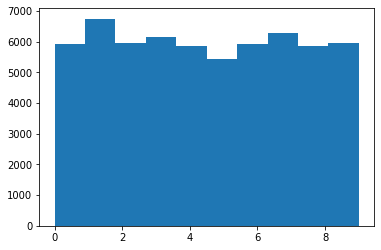

In [17]:
plt.hist(train_labels)
plt.show()

True Label is 9


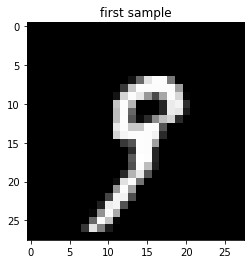

In [18]:
#use matplotlib to plot the first training sample:
plt.imshow(train_images[19,:,:],cmap = 'gray')
plt.title('first sample')
print('True Label is',train_labels[19])
# print(train_images[0,:,:])

## Building the model

### HyperParameters vs Parameters

When we want to build a model we have to carefully design its components: how many hidden layers? how many units per layer? Which optimizer and learning rate value?

Indeed, the behaviour of an algorithm for training a neural network is affected
by a set of **hyperparameters**. Examples of hyperparameters are:
- Number of layers and hidden units: affects the capacity of the model;
- Learning rate: determines the step size in learning procedure;
- Learning rate decay strategy;
- Mini-batch size;
- Number of epochs of training and stop criterion;
- Weights initialization strategy;
- Preprocessing strategy;
- and possibly many others

They are defined *hyperparameters*, as opposed to the *parameters* of a network, i.e. weights and biases that define the behaviour of neurons and are adjusted by the training procedure. That is why *parameters* are referred to as *trainable parameters*.

Defining the correct hyperparameter configuration is of the utmost importance, and it may take days or weeks of tuning. Indeed, an active area of research is *hyperparameter optimization*.

In [19]:
# the number of output units and their activation is determined by our problem: ten digits
output_units = 10
output_activation = 'softmax'

# Hyperparameters
hidden_units = 512
hidden_activation = 'relu'

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential()
network.add(layers.Dense(hidden_units, activation=hidden_activation, input_shape=(28 * 28,))) # we need to specify the input shape
network.add(layers.Dense(output_units, activation=output_activation))
network.summary() # pay attention to the number of parameters. where do they come from?

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Let's evaluate the number of parameters
first_layer = 28*28*512+512

401920

To make our network ready for training, we need to set three more things:

* a loss function;
* an optimizer;
* metrics to monitor during training and testing.

In [23]:
network.compile?

In [24]:
network.compile(optimizer='rmsprop', # rmsprop (Root Mean Square Propagation) is a good choice for the optimizer
                loss='categorical_crossentropy', # categorical crossentropy for a multi-class clasification problem
                metrics=['accuracy']) # accuracy = number of correctly labeled samples / number of samples

Sometimes you may want to configure your optimizer. This can be done by passing an optimizer class instance as the `optimizer` argument.


```python
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
```

Similarly, you can pass custom loss or metric functions as arguments of `compile`.

## Preparing the dataset
Our network is a MLP: we need to reshape images into a vector of input units.

Remember that our network expects a 2D tensor of input shape of (Batch_size, 28*28=784) 

In [25]:
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))


In [26]:
train_images.shape # check the shape!

(60000, 784)

uint8


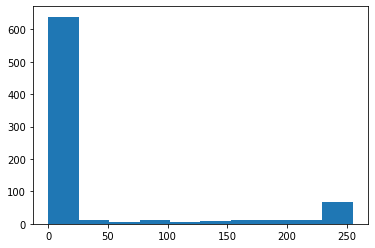

In [27]:
print(train_images[0].dtype) # check the type
plt.hist(train_images[0]) # check the value range and the distribution
plt.show()

Original tensor are of type 'uint8' with values in the range [0,255]. 

We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1

float32


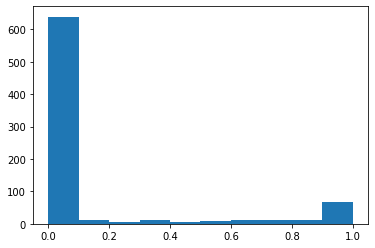

In [28]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255
print(train_images[0].dtype)
plt.hist(train_images[0])
plt.show()

When using the **categorical_crossentropy** loss, your targets should be in categorical (one-hot encoding) format: e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for a 1 at the index corresponding to the class of the sample. In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical:

In [29]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [31]:
train_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Training the model


In [33]:
network.fit?

In [34]:
# other hyperparameters
epochs = 10 # how many times the network experiments the whole training set
batch_size = 128 #how many examples the network exmperiments at every step

In [35]:
history = network.fit(train_images, 
            train_labels, 
            epochs=epochs, 
            batch_size=batch_size,
            shuffle = True)

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2539 - accuracy: 0.9259
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1028 - accuracy: 0.9695
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0676 - accuracy: 0.9800
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0498 - accuracy: 0.9851
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0379 - accuracy: 0.9884
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0288 - accuracy: 0.9911
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0219 - accuracy: 0.9934
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0168 - accuracy: 0.9951
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0124 - accuracy: 0.9965
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0105 - accuracy: 0.9969

In [36]:
history?
history.__dict__

{'_chief_worker_only': None,
 '_supports_tf_logs': False,
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'history': {'accuracy': [0.9259499907493591,
   0.9694666862487793,
   0.9800166487693787,
   0.9850999712944031,
   0.9883999824523926,
   0.9911166429519653,
   0.9934499859809875,
   0.9950833320617676,
   0.9965333342552185,
   0.9968500137329102],
  'loss': [0.25385746359825134,
   0.10282197594642639,
   0.06763873249292374,
   0.049810733646154404,
   0.03788536414504051,
   0.028793828561902046,
   0.021915845572948456,
   0.01677020452916622,
   0.012363581918179989,
   0.010460369288921356]},
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1623d5fc18>,
 'params': {'epochs': 10, 'steps': 469, 'verbose': 1},
 'validation_data': None}

loss [0.25385746359825134, 0.10282197594642639, 0.06763873249292374, 0.049810733646154404, 0.03788536414504051, 0.028793828561902046, 0.021915845572948456, 0.01677020452916622, 0.012363581918179989, 0.010460369288921356]
acc [0.9259499907493591, 0.9694666862487793, 0.9800166487693787, 0.9850999712944031, 0.9883999824523926, 0.9911166429519653, 0.9934499859809875, 0.9950833320617676, 0.9965333342552185, 0.9968500137329102]


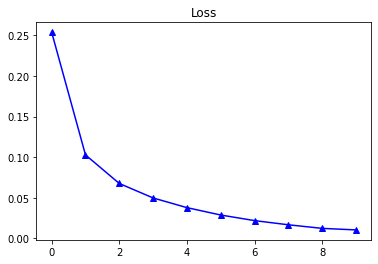

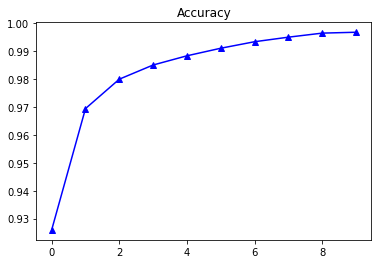

In [37]:
# history.history is a dictionary
loss = history.history["loss"]
acc = history.history["accuracy"]
print('loss',loss)
print('acc',acc)
plt.figure()
plt.plot(loss,'^-b')
plt.title('Loss')
plt.show()
plt.figure()
plt.plot(acc,'^-b')
plt.title('Accuracy')
plt.show()

## Evaluate the model on the Test Set



Let's check that our model performs well on the test set too:

In [38]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)


313/313 [==============================] - 1s 2ms/step - loss: 0.0734 - accuracy: 0.9822
test_acc: 0.982200026512146


What's happening here? We will obtain test accuracy step by step.

In [39]:
predictions = network.predict(test_images) # get the output for each sample
predictions[0]

array([1.1178026e-12, 6.2986916e-16, 1.9596871e-09, 1.1531361e-06,
       3.6541324e-16, 1.2985900e-11, 3.3983911e-18, 9.9999881e-01,
       2.2364871e-10, 1.9057007e-09], dtype=float32)

In [40]:
predicted_lab = np.argmax(predictions,axis=1) # from one-hot encoding to integer
test_lab = np.argmax(test_labels,axis=1) # from one-hot encoding to integer
predicted_lab.shape,test_lab.shape

((10000,), (10000,))

In [41]:
correct_predictions = np.sum(np.equal(predicted_lab,test_lab))
accuracy = correct_predictions/len(test_lab)
print(accuracy)

0.9822


In [42]:
#save the trained model, we will compare its performance with another, more sofisticated, model
network.save(os.path.join(dir_name,"MNIST_MLP.h5"))  # creates a HDF5 file 'my_model.h5'
del network

In [44]:
try:
  predictions = network.predict(test_images) # get the output for each sample
except NameError as exc:
  print(exc)

name 'network' is not defined


In [45]:
# try to load the model again
from tensorflow.keras.models import load_model

model = load_model(os.path.join(dir_name,"MNIST_MLP.h5"))
test_loss, test_acc = model.evaluate(test_images,test_labels)

print('test_acc:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0734 - accuracy: 0.9822
test_acc: 0.982200026512146


In [46]:
# useful to free GPU and memory
from tensorflow.keras import backend as K
del model
K.clear_session() 


# Part 2


## Dataset: Training set, Validation set and Test set
The final goal of a classification algorithm is to correctly classify a previously unseen example. Therefore it is not sufficient to solve an optimization problem on the examples used for training. 

To evaluate this **generalization capability** the input dataset is split into two separate sets:  training set and test set. The training set is often further split in training set and validation set.
- the **training set** is used during training in order to increase the experience of the model. An optimization procedure finds the parameters configuration which minimizes the training error.
- the **validation set** is a collection of examples that are not used for training: being part of the training set, we are allowed to modify the hyper-parameters of the model according to the performance of the algorithm on this set.
- the **test set** is used to measure the actual performance of the model, thus its generalization capability. 

The inference capability on previously unseen examples arises from an assumption about data generating process (i.i.d. assumption): examples in training and test sets are supposed to be independent from each other and identically distributed.


## Capacity, Overfitting, Underfitting
The **capacity** of a model corresponds to its degree of complexity: higher the capacity (to a first approximation, the number of parameters), wider the variety of functions it will be able to fit.

If the model is given a low capacity, the error on the training set will be high: this situation is called **underfitting**. 

If the model is given a high capacity, it will overfit the training set, losing the capability to generalize well on a test-set. This situation is called **overfitting**. 

## Back to the MNIST example: Reduced training set

We put ourselves in a more challenging situation: we select a random subset of our training set to simulate a low data regime, i.e. few samples for training.

We will evaluate two different models:
- **base model** will overfit the training data
- **regularized model** will try to fight overfitting

In [47]:
# select the subset of the training set
subset_size = 6000
subset_index = np.random.choice(range(len(train_labels)),size = subset_size)
train_images_subset = train_images[subset_index,:]
train_labels_subset = train_labels[subset_index,:]


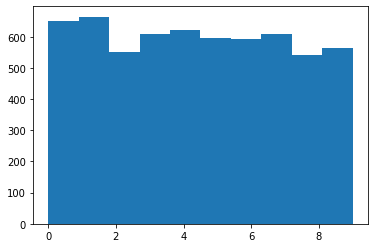

In [48]:
plt.hist(np.argmax(train_labels_subset,axis = 1))
plt.show()

### First model: Base Model

From the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

**validation_split**: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.

In [49]:
from tensorflow.keras import models
from tensorflow.keras import layers


base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(28*28,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(10, activation='softmax'))
base_model.summary() 
base_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
history_base = base_model.fit(train_images_subset, 
            train_labels_subset, 
            epochs=30, 
            batch_size=batch_size,
            validation_split = 0.1, # evaluate the generalization capability of our model 
            shuffle = True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
43/43 [==============================] - 0s 6ms/step - loss: 1.3834 - accuracy: 0.6085 - val_loss: 0.6580 - val_accuracy: 0.8300
Epoch 2/30
43/43 [==============================] - 0s 3ms/step - loss: 0.4731 - accuracy: 0.8731 - val_loss: 0.4252 - val_accuracy: 0.8850
Epoch 3/30
43/43 [==============================] - 0s 3ms/step - loss: 0.3409 - accuracy: 0.9069 - va

In [50]:
test_loss, test_acc = base_model.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.2879 - accuracy: 0.9335
test_acc: 0.9334999918937683


In [51]:
del base_model
print('model deleted')
K.clear_session()

model deleted


### Second model: Regularized Model

A form of regularization is added to our model: it consists in a modiﬁcation to our learning algorithm that aims at reducing its generalization error but not its training error.

In [52]:
from tensorflow.keras import models
from tensorflow.keras import layers

regularized_model = models.Sequential()
regularized_model.add(layers.Dense(64, activation='relu', input_shape=(28*28,)))
regularized_model.add(layers.Dropout(0.1))
regularized_model.add(layers.Dense(64, activation='relu'))
regularized_model.add(layers.Dropout(0.1))
regularized_model.add(layers.Dense(10, activation='softmax'))
regularized_model.summary() 
regularized_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
history_regularized = regularized_model.fit(train_images_subset, 
            train_labels_subset, 
            epochs=30, 
            batch_size=batch_size,
            validation_split = 0.1,
            shuffle = True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
43/43 [==============================] - 0s 6ms/step - loss: 1.5128 - accuracy: 0.5437 - val_loss: 0.7468 -

In [ ]:
print('base model accuracy:', test_acc)
test_loss, test_acc = regularized_model.evaluate(test_images, test_labels)
print('regularized model accuracy:', test_acc)

In [ ]:
del regularized_model
K.clear_session()

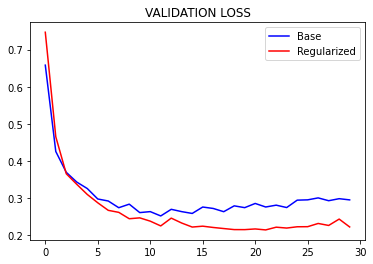

In [53]:
plt.title('VALIDATION LOSS')
plt.plot(history_base.history['val_loss'],'b-',label = 'Base')
plt.plot(history_regularized.history['val_loss'],'r-',label = 'Regularized')
plt.legend()
plt.show()

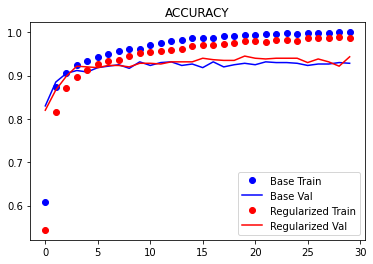

In [54]:
plt.title('ACCURACY')
plt.plot(history_base.history['accuracy'],'bo',label = 'Base Train ')
plt.plot(history_base.history['val_accuracy'],'b-',label = 'Base Val')
plt.plot(history_regularized.history['accuracy'],'ro',label = 'Regularized Train')
plt.plot(history_regularized.history['val_accuracy'],'r-',label = 'Regularized Val')
plt.legend()
plt.show()

Note that:
- validation loss curve for regularized model shows a slight improvement with regard to the one of base model.
- notwithstanding, validation accuracy for the base model closely trails the one of regularized model. 

Why is the gap between the loss plots not also found in the accuracy plots?


To answer this question, consider that what we display is an average of pointwise loss values, but what actually matters for accuracy is the distribution of the loss values, not their average:  accuracy, in fact, is the result of a thresholding of the class probability predicted by the model. Indeed, the model may still be improving even if this isn't reflected in the average loss.

## Fighting Overfitting
The most common ways to prevent overfitting in neural networks are:
- **Getting more training data**: a model trained on more (quality) data will naturally generalize better. Gathering more data may be even more useful than improving the learning algorithm.

- **Performing dataset augmentation**: The restricted size of available databases is one of the central issue in many machine learning applications. Gathering and annotating new data is often a difficult task. A solution, particularly adopted with images, is to introduce several types of transformation or distortion that consist in an artificial dataset augmentation. 

- **Reducing the capacity of the network**: Overfitting is the use of models or procedures that violate [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor) (paraphrasable as: *The simplest solution is most likely the right one*) for example by uselessly including a high number of adjustable parameters, or by using a more complicated approach than the one is ultimately optimal. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the patterns that have a better chance of generalizing well.

- **Adding weight regularization**: this technique consists in forcing the weights of a network to only take small values: it is achieved by adding a parameter norm penalty $\theta(w)$ (associated with having large weights) to the loss function of the network $J(w)$. As a consequentce: $J(w) = J(w)+\lambda\theta(w)$. For example:
  - with *L2 regularization*, the penalty is proportional to the squared value of the weights coefficients
  - with *L1 regularization*, the penalty is proportional to the absolute value of the weights coefficients

- **Adding dropout**: this technique is widely used to reduce overfitting in neural network: when dropout is applied to a layer, at every training step every unit of that layer is kept with probability p, otherwise it is temporarily ignored. During evaluation (i.e. inference on validation or test set) the dropout is turned-off and all the
neurons are kept.  Dropout effect could be seen from two points of view. On one hand, by randomly sampling the neurons to delete at every step, it reduces the co-adaptation phenomenon between neurons; on the other hand, it results in a procedure that trains a variety of different neural networks (i.e. different number of units per layer). These subnetworks are supposed to overfit the training set in different way, so the global network should be able to generalize better.<br>
![dropout](https://static.commonlounge.com/fp/600w/aOLPWvdc8ukd8GTFUhff2RtcA1520492906_kc)
<br>

[Geoffry Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton) - The idea behind dropout: "*I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting.*"




# Further reading
- Interactive learning with [Tensorflow Playground](https://playground.tensorflow.org)

# Exercise

Try to vary the hyperparameter of your model
- number of layers / units per layer
- optimizer learning rate
- dropout rate
- Add L1 or L2 regularization
  - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense  
  - https://www.tensorflow.org/api_docs/python/tf/keras/regularizers


Share your best model (highest final validation accuracy) with the class!

